# Stoichiometric Structure
Part I of this book introduced the basics of dynamic simulation. The process for setting up dynamic equations, their simulation, and processing of the output was presented in Chapter 3. Several concepts of dynamic analysis of networks were illustrated through the use of simple examples of chemical reaction mechanisms in Chapters 4 through 6. Most of these examples were conceptual and had limited direct biological relevance. In Chapter 7 we began to estimate the numerical values and ranges for key quantities in dynamic models. With this background, we now begin the process of addressing issues that are important when one builds realistic dynamic models of biological functions. We start by exploring the consequences of reaction bilinearity and that of the stoichiometric structure of a network. In Part III we then extend the material in this chapter to well-known metabolic pathways.  

**MASSpy** will be used to demonstrate some of the topics in this chapter.  

In [1]:
from mass import (
    MassModel, MassMetabolite, MassReaction,
    Simulation, MassSolution, strip_time)
from mass.util.matrix import nullspace, left_nullspace
from mass.visualization import plot_time_profile, plot_phase_portrait

Other useful packages are also imported at this time.

In [2]:
import numpy as np
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
XL_FONT = {"size": "x-large"}

## Bilinearity in Biochemical Reactions
### Bilinear reactions 
They are of the form:

$$\begin{equation} x + y \rightarrow z \tag{8.1} \end{equation}$$

Two molecules come together to form a new molecule through the breaking and forming of covalent bonds, or a complex through the formation of hydrogen bonds. As illustrated with the pool formations in the bilinear examples in Chapter 4, such reactions come with moiety exchanges. 

### Enzyme classification  
Enzyme catalyzed reactions are classified in to seven categories by Enzyme Commission (EC) numbers, see Figure 8.1a.  These categories are: oxidoreductases, transferases, hydrolases, lyases, isomerases, and ligases. All these chemical transformations are bilinear with the exception of isomerases that simply rearrange a molecule without the participation of other reactants. Thus, the vast majority of biochemical reactions are bilinear. An overall pseudo-elementary representation (i.e., without treating the enzyme itself as a reactant, and just representing the un-catalyzed reaction) is bilinear. 

![Figure-8-1](../images/Ch8/Figure-8-1.png)

**Figure 8.1:** The bilinear nature of biochemical reactions. (a) The classification of enzyme catalyzed reactions into seven categories by the enzyme commission (EC) number system. (b) The detailed view of the role of coenzymes and prosthetic groups in enzyme catalyzed reactions. Coenzymes are often referred to as cofactors. Both images from Koolman, 2005 (reprinted with permission).

### Coenzymes and prosthetic groups  
There are coenzymes and prosthetic groups that are involved in many biochemical reactions. These molecules are involved in group transfer reactions as illustrated in Figure 8.1b. They can transfer various chemical moieties or redox equivalents, see Table 8.1. Coenzymes act like a reactant and product in a reaction.  They can work with many enzymes performing reactions that need them.  Prosthetic groups  associate with a particular enzyme to give it chemical functionalities that the protein itself does not have, Figure 8.1b. The heme group on hemoglobin is perhaps the most familiar example (see Chapter 13) that allows the protein tetramer to acquire a ferrous ion thus enabling the binding of oxygen.  This binding allows the red blood cell to perform its oxygen delivery functions. There are many such capabilities 'grafted' onto proteins in the form of prosthetic groups. Many of the vitamins confer functions on protein complexes. 

## Bilinearity Leads to a Tangle of Cycles
### Moiety exchange:  
Biochemical reaction networks are primarily made up of bilinear reactions. A fundamental consequence of this characteristic is a deliberate exchange of chemical moieties and properties between molecules. This exchange is illustrated in Figure 8.2. Here, an incoming molecule, $XA$, puts the moiety, $A$, onto a carrier molecule, $C$. The carrier molecule, now in a 'charged' form $(CA)$, can donate the $A$ moiety to another molecule, $Y$, to form $YA$. The terms _coenzyme,_ _cofactor_ or _carrier_ are used to describe the $C$ molecule.

![Figure-8-2](../images/Ch8/Figure-8-2.png)

**Figure 8.2:** Carrier $(C)$ mediated transfer of chemical moiety $A$ from compound $X$ to compound $Y$.

### Formation of cycles:  
The ability of bilinear reactions to exchange moieties in this fashion leads to the formation of distribution networks of chemical moieties and other properties of interest through the formation of a deliberate 'supply-chain' network. The structure of such a network must be thermodynamically feasible and conform to environmental constraints. 

Bilinearization in biochemical reaction networks leads to a 'tangle of cycles,' where different moieties and properties are being moved around the network. While a property of all biochemical networks, this trafficking of chemical and other properties is best known in metabolism. The major chemical properties that are being exchanged in metabolism are summarized in Table 8.1. These properties include energy, redox potential, one-carbon units, two-carbon units, amide groups, amine groups, etc. We now consider some specific cases. 

**Table 8.1:** Some activated carriers or coenzymes in metabolism, modified from Kurganov, 1983.

![Table-8-1](../images/Ch8/Table-8-1.png)

#### Example: Redox and energy trafficking in the core _E. coli_ metabolic pathways  
Energy metabolism revolves around the generation of redox potential and chemical energy in the form of high-energy phosphate bonds. The degradation of substrates through a series of chemical reactions culminates in the storage of these properties on key carrier molecules; see Table 8.1. 

The core metabolic pathways in _E. coli_ illustrate this feature, Figure 8.3. The transmission of redox equivalents through this core set of pathways is shown in Figure 8.3a. Each pathway is coupled to a redox carrier in a particular way. This pathway map can be drawn to show the cofactors rather than the primary metabolites and the main pathways (Figure 8.3b). This figure clearly shows how the cofactors interact and how the bilinear property of the stoichiometry of the core set of pathways leads to a tangle of cycles among the redox carriers. 

![Figure-8-3](../images/Ch8/Figure-8-3.png)

**Figure 8.3:** The tangle of cycles in trafficking of redox potential (R) in _E. coli_ core metabolic pathways. (a) A map organized around the core pathways. (b) The tangle of cycles seen by viewing the cofactors and how they are coupled. Prepared by Jeff Orth.

#### Example: Protein trafficking in signaling pathways  
Although the considerations above are illustrated using well-known metabolic pathways, these same features are also observed in signaling pathways. Incoming molecules (ligands) trigger a well-defined series of charging and discharging of the protein that make up a signaling network, most often with a phosphate group. 

## Trafficking of High-Energy Phosphate Bonds
Given the bilinear nature of biochemical reaction networks and the key role that cofactors play, we begin the process of building biologically meaningful simulation models by studying the use and formation of high-energy phosphate bonds. Cellular energy is stored in high-energy phosphate bonds in ATP. The dynamic balance of the rates of use and formation of ATP is thus a common denominator in all cellular processes, and thus foundational to the living process. We study the dynamic properties of this system in a bottom-up fashion by starting with its simple elements and making the description progressively more complicated. Throughout the text we make explicit use of the basic methods in **MASSpy**.

![Figure-8-4](../images/Ch8/Figure-8-4.png)

**Figure 8.4:** Representation of the exchange of high energy phosphate bonds among the adenosine phosphates. (a) The chemical reactions. (b) The molecules with open circles showing the "vacant" places for high energy bonds. The capacity to carry high-energy phosphate bonds, the occupancy of high-energy bonds, and the energy charge are shown. (c) The reaction schema of (a) in pictorial form. The solid squares represent AMP and the solid circles the high energy phosphate bonds. (d) The same concepts as in (b) represented in pictorial form.

### Distribution of high-energy phosphate groups: adenylate kinase (EC 2.7.4.3)
The Adenylate Kinase is an important part in intracellular energy homeostasis. Adenylate Kinase is a phosphotransferase enzyme and it is the enzyme responsible for the redistribution of the phosphate groups among the adenosine phosphates. The redistribution reaction the Adenylate Kinase catalyzes is seen in Figure 8.4a.

#### The mass balance:  adenylate kinase
The redistribution of the phosphate groups among the adenosine phosphates by the adenylate kinase is given by the following kinetic equations:

$$\begin{equation} \frac{d\text{ATP}}{dt} = v_{\mathrm{distr}}, \ \frac{d\text{ADP}}{dt} = -2\ v_{\mathrm{distr}}, \ \frac{d\text{AMP}}{dt} = v_{\mathrm{distr}} \tag{8.2} \end{equation}$$

#### The reaction rates: adenylate kinase
The mass action form of these basic reaction rates are 

$$\begin{equation} v_{\mathrm{distr}} = k_{\mathrm{distr}}^\rightarrow\text{ADP}^2 - k_{\mathrm{distr}}^\leftarrow\text{ATP}*\text{AMP} \tag{8.3} \end{equation}$$

#### Numerical values: adenylate kinase
The approximate numerical values of the parameters in this system can be estimated. In metabolically active tissues, the ATP concentration is about 1.6 mM, the ADP concentration is about 0.4 mM, and the AMP concentration is about 0.1 mM.  Total adenosine phosphates are thus about 2.1 mM. Because this reaction is considerably faster compared to other metabolic processes, we set $k_{\mathrm{distr}}^\rightarrow$ to 1000/Min. $K_{\mathrm{distr}}$ for the distribution reaction is approximately unity. We then construct a model of the redistribution of phosphate groups among the adenosine phosphates by adenylate kinase using the above constraints.  This is simple reversible reaction that equilibrates quickly.

![Figure-8-5](../images/Ch8/Figure-8-5.png)

**Figure 8.5:** The redistribution of phosphate groups among the adenosine phosphates by adenylate kinase.

In [3]:
phos_traffic = MassModel("Phosphate_Trafficking", array_type="DataFrame",
                         dtype=np.int64)
# Define metabolites
atp = MassMetabolite("atp")
adp = MassMetabolite("adp")
amp = MassMetabolite("amp")
# Define reactions
v_distr = MassReaction("distr")
v_distr.add_metabolites({adp: -2, amp: 1, atp:1})

# Add reactions to model
phos_traffic.add_reactions([v_distr])

# Define initial conditions and parameters
atp.ic = 1.6
adp.ic = 0.4
amp.ic = 0.1

v_distr.kf = 1000
v_distr.Keq = 1

#### Null spaces: adenylate kinase
The stoichiometric matrix is basically a column vector.

In [4]:
phos_traffic.S

,distr
adp,-2
amp,1
atp,1


It has an empty null space; i.e. zero dimensional.

In [5]:
nullspace(phos_traffic.S, rtol=1e-1)

array([], shape=(1, 0), dtype=float64)

However, the left null space has two dimensions and it thus has two conservation pools. 

In [6]:
# Obtain left nullspace
lns = left_nullspace(phos_traffic.S, rtol=1e-1)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, index=["Vacancy", "Occupancy"], 
             columns=phos_traffic.metabolites, dtype=np.int64)

,adp,amp,atp
Vacancy,1,2,0
Occupancy,1,0,2


The interpretation of these pools is remarkably interesting:  the first one counts the number of high energy phosphate bonds in the system, while the second counts the number of vacant spots where high energy phosphate bonds can be added.  The left null space is spanned by these two vectors that we can think of as a conjugate pair.  Furthermore, the summation of the two is the total amount of the 'A' nucleotide in the system times two; ie the total number of possible high-energy phosphate bonds that the system can carry.  

In [7]:
# Sum the elements of each row to obtain the capacity pool
capacity = np.array([np.sum(lns, axis=0)])
pd.DataFrame(capacity, index=["Capacity"],
             columns=phos_traffic.metabolites, dtype=np.int64)

,adp,amp,atp
Capacity,2,2,2


Note that any activity of this reaction does not change the sizes of these two pools as the left null space is orthogonal to the reaction vector (or the column vector of $(\textbf{S})$, that represents the direction of motion.

### Using and generating high-energy phosphate groups  
We now introduce the 'use' and 'formation' reactions for ATP into the above system.  These represent aggregate processes in the cell using and forming high energy bonds.

#### The mass balances: trafficking high-energy phosphate bonds
$$\begin{align} \frac{d\text{ATP}}{dt} &= -v_{\mathrm{use}} + v_{\mathrm{form}} + v_{\mathrm{distr}} \tag{8.4} \\ \frac{d\text{ADP}}{dt} &= v_{\mathrm{use}} - v_{\mathrm{form}} - 2\ v_{\mathrm{distr}} \tag{8.5} \\ \frac{d\text{AMP}}{dt} &= v_{\mathrm{distr}} \tag{8.6} \end{align}$$

where $v_{\mathrm{use}}$ is the rate of use of ATP, $v_{\mathrm{form}}$ is the rate of formation of ATP, and, as above, $v_{\mathrm{distr}}$ is the redistribution of the phosphate group among the adenosine phosphates by adenylate kinase. 

#### The reaction rates: trafficking high-energy phosphate bonds
Elementary mass action form for the two additional rate equations are 

$$\begin{equation} v_{\mathrm{use}} = k_{\mathrm{use}}^\rightarrow \text{ATP},\ v_{\mathrm{form}} = k_{\mathrm{form}}^\rightarrow\text{ADP}\tag{8.7} \end{equation}$$ 

#### Numerical values: trafficking high-energy phosphate bonds
We use the equilibrium concentrations from the distribution model and estimate in the numerical values for the rate constants of ATP use and formation based on the fact that typical use and formation rates of ATP are about 10 mM/min. Using the steady state concentrations, we can calculate $k_{\mathrm{use}}^\rightarrow$ and $k_{\mathrm{form}}^\rightarrow$, resulting in $k_{\mathrm{use}}^\rightarrow=6.25\ min^{-1}$ and $k_{\mathrm{form}}^\rightarrow=25\ min^{-1}$. These constants are known as Pseudo-Elementary Rate Constants (PERCs). They are a ratio between the flux through a reaction and the concentrations of the involved species, and the simplify the network dynamic analysis. However they are condition dependent and result in a condition dependent kinetic model. What comprises the PERCs is explored further in the later chapters.  

We update the distribution model with the additional reactions and parameters. 

![Figure-8-6](../images/Ch8/Figure-8-6.png)

**Figure 8.6:** The trafficking of high-energy phosphate bonds.

In [8]:
# Create utilization reaction
v_use = MassReaction("use", reversible=False)
v_use.add_metabolites({atp: -1, adp: 1})
v_use.kf = 6.25

# Create formation reaction
v_form = MassReaction("form", reversible=False)
v_form.add_metabolites({adp: -1, atp: 1})
v_form.kf = 25

# Add reactions to model
phos_traffic.add_reactions([v_use, v_form])

# View rate of distribution reaction
print(v_distr.rate)

kf_distr*(adp(t)**2 - amp(t)*atp(t)/Keq_distr)


From the model we also see that the net rate for the redistribution of high-energy bonds is

$$\begin{align} v_{\mathrm{distr}} &= k_{\mathrm{distr}}^\rightarrow\ \text{ADP}^2 - k_{\mathrm{distr}}^\leftarrow\text{ATP}*\text{AMP} &\tag{8.8a} \\ &= k_{\mathrm{distr}}^\rightarrow( \text{ADP}^2 - \text{ATP}*\text{AMP}/K_{\mathrm{distr}}) &\tag{8.8b} \end{align}$$

#### Null spaces: trafficking high-energy phosphate bonds
Now the stoichiometric matrix three columns. 

In [9]:
phos_traffic.S

,distr,use,form
adp,-2,1,-1
amp,1,0,0
atp,1,-1,1


It has a one-dimensional null space, that represents an internal loop as the use and formation reactions are the exact opposites of each other.

In [10]:
# Obtain nullspace
ns = nullspace(phos_traffic.S, rtol=1e-1)
# Transpose and iterate through nullspace, 
# dividing by the smallest value in each row.
ns = ns.T
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])

    
# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Revert transpose
ns = ns.T
# Create a pandas.DataFrame to represent the nullspace
pd.DataFrame(ns, index=[rxn.id for rxn in phos_traffic.reactions],
             columns=["Path 1"], dtype=np.int64)

,Path 1
distr,0
use,1
form,1


The left null space is now one-dimensional;

In [11]:
# Obtain left nullspace
lns = left_nullspace(phos_traffic.S, rtol=1e-1)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, index=["Total AxP"], 
             columns=phos_traffic.metabolites, dtype=np.int64)

,adp,amp,atp
Total AxP,1,1,1


#### Dynamic simulations: trafficking high-energy phosphate bonds 
The system is steady at the initial conditions given

In [12]:
t0, tf = (0, 1e3)
sim = Simulation(phos_traffic, verbose=True)
conc_sol, flux_sol = sim.simulate(
    phos_traffic, time=(t0, tf, tf*10 + 1), interpolate=True,
    verbose=True)

Successfully loaded MassModel 'Phosphate_Trafficking' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Phosphate_Trafficking'
Simulating 'Phosphate_Trafficking'
Simulation for 'Phosphate_Trafficking' successful
Adding 'Phosphate_Trafficking' simulation solutions to output
Updating stored solutions


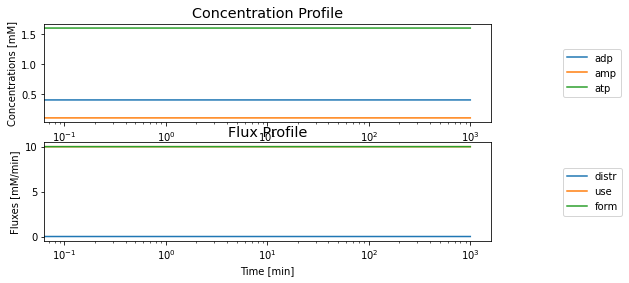

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4),
                         )
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1,
    legend="right outside",plot_function="semilogx", 
    xlabel="Time [min]", ylabel="Concentrations [mM]", 
    title=("Concentration Profile", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2,
    legend="right outside", plot_function="semilogx", 
    xlabel="Time [min]", ylabel="Fluxes [mM/min]", 
    title=("Flux Profile", XL_FONT));

We can induce motion in the system by taking 0.2 mM of ADP and splitting it into 0.1 mM addition to AMP and ATP, and set the initial conditions as ATP is 1.7 mM, ADP is 0.2 mM, and AMP is 0.2 mM and simulate the dynamic response.  We graph the concentration profiles, as well as the two pools and the disequilibrium variable: $\text{ADP}^2 - \text{ATP}*\text{AMP}$ that is zero at the equilibrium

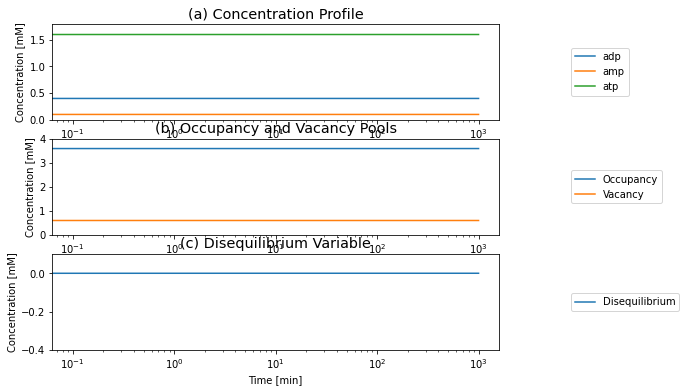

In [14]:
# Define pools and perturbations
pools = {"Occupancy": "adp + 2*atp", 
         "Vacancy": "adp + 2*amp", 
         "Disequilibrium": "adp**2 - atp*amp"}

# Simulate with disturbance
conc_sol, flux_sol = sim.simulate(
    phos_traffic, time=(t0, tf, tf*10 + 1),
    perturbations={"atp": 1.7, "adp": 0.2, "amp": 0.2})

# Determine pools
for pool_id, equation_str in pools.items():
    conc_sol.make_aggregate_solution(
        pool_id, equation=equation_str, update=True)

# Visualize solutions
fig_8_7, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6),)
(ax1, ax2, ax3) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, observable=phos_traffic.metabolites,
    legend="right outside", plot_function="semilogx", ylim=(0, 1.8),
    xlabel="Time [min]", ylabel="Concentration [mM]",
    title=("(a) Concentration Profile", XL_FONT));

plot_time_profile(
    conc_sol, observable=["Occupancy", "Vacancy"], ax=ax2, 
    legend="right outside", plot_function="semilogx", ylim=(0., 4.),
    xlabel="Time [min]", ylabel="Concentration [mM]",
    title=("(b) Occupancy and Vacancy Pools", XL_FONT));

plot_time_profile(
    conc_sol, observable=["Disequilibrium"], ax=ax3,
    legend="right outside", plot_function="semilogx", ylim=(-.4, 0.1),
    xlabel="Time [min]", ylabel="Concentration [mM]",
    title=("(c) Disequilibrium Variable", XL_FONT));

**Figure 8.7:** The time response of the adenylate kinase reaction ("distr") and with the addition of ATP use and formation to a change in the initial conditions. (a) The concentrations. (b) The occupancy and capacity pools. (c) The disequilibrium variable.

#### Towards a realistic simulation of a dynamic response
Next, we simulate the response of this system to a more realistic perturbation: a 50% increase in the rate of ATP use. This would represent a sudden increase in energy use by a cell.  At time zero, we have the network in a steady state and we change $k_{\mathrm{use}}^\rightarrow$ from $6.25/min$ to $1.5*6.25=9.375/min$, and the rate of ATP use instantly becomes 15 mM/min. 

The response of the system is perhaps best visualized by showing the phase portrait of the rate of ATP use versus ATP formation. Prior to the increased load, the system is on the 45 degree line, where the rate of ATP formation and use balances.  Then at time zero it is instantly imbalanced by changing $k_{\mathrm{use}}^\rightarrow$ above or below its initial value. If $k_{\mathrm{use}}^\rightarrow$ is increased then the initial point moved into the region where more ATP is used than formed. From this initial perturbation the response of the system is to move directly towards the 45 degree line to regain balance between ATP use and formation.

In [15]:
t0, tf = (0, 1e3)
# Simulate with disturbance
conc_sol, flux_sol = sim.simulate(
    phos_traffic, time=(t0, tf, tf*10 + 1), 
    perturbations={"kf_use": "kf_use * 1.5"},
    verbose=True)

# Determine pools
for pool_id, equation_str in pools.items():
    conc_sol.make_aggregate_solution(
        pool_id, equation=equation_str, update=True)

Getting time points
Parsing perturbations
Setting output selections
Setting simulation values for 'Phosphate_Trafficking'
Simulating 'Phosphate_Trafficking'
Simulation for 'Phosphate_Trafficking' successful
Adding 'Phosphate_Trafficking' simulation solutions to output
Updating stored solutions


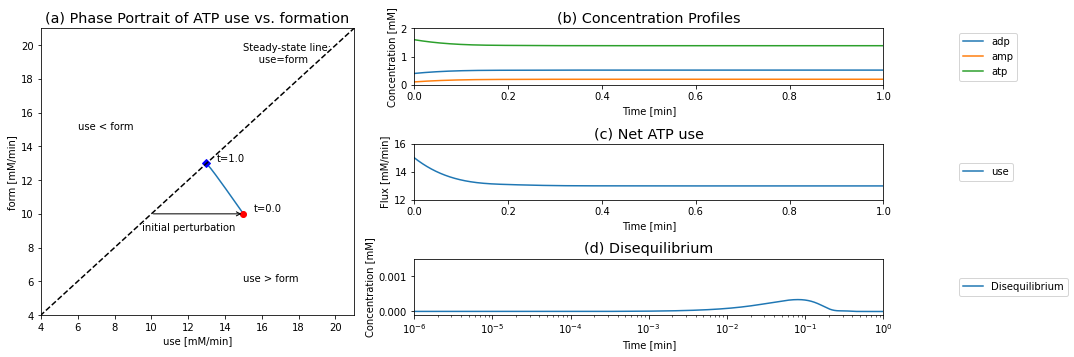

In [16]:
fig_8_8 = plt.figure(figsize=(15, 5))
gs = fig_8_8.add_gridspec(nrows=3, ncols=2, width_ratios=[1, 1.5])

ax1 = fig_8_8.add_subplot(gs[:, 0])
ax2 = fig_8_8.add_subplot(gs[0, 1])
ax3 = fig_8_8.add_subplot(gs[1, 1])
ax4 = fig_8_8.add_subplot(gs[2, 1])

label = "{0} [mM/min]"
plot_phase_portrait(
    flux_sol, x=v_use, y=v_form, ax=ax1,
    time_vector=np.linspace(t0, 1, int(1e4)),
    xlabel=label.format(v_use.id), ylabel=label.format(v_form.id), 
    xlim=(4, 21), ylim=(4, 21), 
    title=("(a) Phase Portrait of ATP use vs. formation", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_labels=True);

line_data = [i for i in range(0, 22)]
ax1.plot(line_data, line_data, ls="--", color="black")
ax1.annotate("use < form", xy=(6, 15))
ax1.annotate("use > form", xy=(15, 6))
ax1.annotate("Steady-state line:\n     use=form", xy=(15, 19))
ax1.annotate("initial perturbation", xy=(9.5, 9), xycoords="data")
ax1.annotate("", xy=(flux_sol[v_use.id][0], flux_sol[v_form.id][0]),
             xytext=(10, 10), textcoords="data",
             arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))

plot_time_profile(
    conc_sol, observable=phos_traffic.metabolites,
    ax=ax2, legend="right outside",
    time_vector=np.linspace(t0, 1, int(1e5)),
    xlim=(t0, 1), ylim=(0, 2),
    xlabel="Time [min]", ylabel="Concentration [mM]",
    title=("(b) Concentration Profiles", XL_FONT));

plot_time_profile(
    flux_sol, observable=[v_use],
    ax=ax3, legend="right outside",
    time_vector=np.linspace(t0, 1, int(1e5)),
    xlim=(t0, 1), ylim=(12, 16),
    xlabel="Time [min]", ylabel="Flux [mM/min]",
    title=("(c) Net ATP use", XL_FONT));

plot_time_profile(
    conc_sol, observable="Disequilibrium",
    ax=ax4, legend="right outside",
    time_vector=np.linspace(t0, 1, int(1e5)), plot_function="semilogx", 
    xlabel="Time [min]", ylabel="Concentration [mM]",
    xlim=(1e-6, 1), ylim=(-.0001, 0.0015),
    title=("(d) Disequilibrium", XL_FONT));
fig_8_8.tight_layout()

**Figure 8.8:** Dynamic responses for Eqs (8.4 - 8.8). (a) The phase portrait for the rates of use and formation of ATP. (b) The concentrations of ATP, ADP, and AMP. (c) Net ATP use (d) The disequilibrium variable for Adenylate kinase.

#### Pooling and interpretation: trafficking high-energy phosphate bonds
Since AMP is not being synthesized and degraded, the sum of $\text{ATP} + \text{ADP} +\text{AMP}$, or the capacity to carry high-energy phosphate bonds, is a constant. The Atkinson's energy charge 

$$\begin{equation} \text{E.C.} = \frac{2\ \text{ATP} + \text{ADP}}{2\ \text{ATP}+\text{ADP}+\text{AMP}} = \frac{\text{occupancy}}{\text{capacity}} \tag{8.9} \end{equation}$$

shows a monotonic decay to a lower state in response to the increased load  (see Figure 8.9). 

In [17]:
pools.update({"EC": "(2*atp + adp) / (2*(atp + adp + amp))"})
# Determine pools
for pool_id, equation_str in pools.items():
    conc_sol.make_aggregate_solution(
        pool_id, equation=equation_str, update=True)

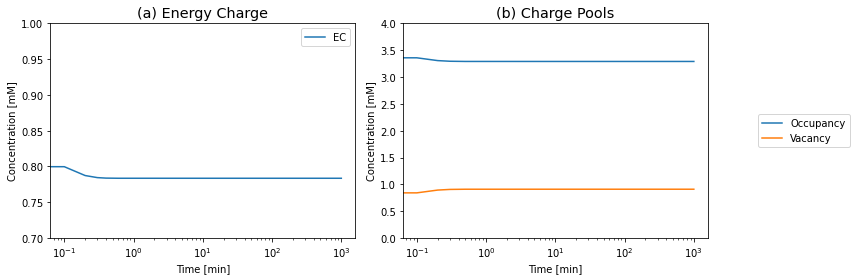

In [18]:
fig_8_9, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, observable=["EC"], ax=ax1, legend="best",
    plot_function="semilogx", ylim= (.7, 1),
    xlabel="Time [min]", ylabel="Concentration [mM]",
    title=("(a) Energy Charge", XL_FONT));

plot_time_profile(
    conc_sol, observable=["Occupancy", "Vacancy"], ax=ax2, 
    legend="right outside", plot_function="semilogx",
    ylim=(0., 4.), xlabel="Time [min]", ylabel="Concentration [mM]",
    title=("(b) Charge Pools", XL_FONT));
fig_8_9.tight_layout()

**Figure 8.9:** (a) The Atkinson's energy charge (Eq. 8.9). (b) The occupancy and vacancy pools move in the opposite directions. Increasing the load drops the occupancy pool and increases the vacancy pool as the system becomes discharged. Reduced loads have the opposite reaction.

![Figure-8-10](../images/Ch8/Figure-8-10.png)

**Figure 8.10:** Graphical representation of the energy charge (x-direction) versus the capacity (y-direction). The drop in the charge is indicated by the arrow. The capacity is a constant in this case.

### Buffering the energy charge  
#### Reaction mechanism:  E.C. buffering
In many situations, there is a buffering effect on the energy charge by a coupled carrier of high energy bonds. This exchange is: 

$$\begin{equation} \text{ATP}\ + \text{B} \leftrightharpoons \text{ADP}\ + \text{BP} \tag{8.10} \end{equation}$$

where the buffering molecule, $\text{B}$, picks up the high-energy phosphate group through a fast equilibrating reaction. 

![Figure-8-11](../images/Ch8/Figure-8-11.png)

**Figure 8.11:** The trafficking of high-energy phosphate bonds with the buffer molecule exchange reaction.

In [19]:
# Copy the model to create a new, yet identical model instance 
phos_buffered = phos_traffic.copy()
phos_buffered.id += "_Buffered"

# Create the buffer metabolites
b = MassMetabolite("b")
bp = MassMetabolite("bp")

# Create the buffer reaction and add the metaolites
v_buff = MassReaction("buff")
v_buff.add_metabolites({atp:-1, b:-1, adp:1, bp:1})

# Update model
phos_buffered.add_reactions(v_buff)

The rate equation of the buffering reaction is:

In [20]:
print(strip_time(phos_buffered.rates[v_buff]))

kf_buff*(atp*b - adp*bp/Keq_buff)


#### Examples of buffer molecules  
In Eq. (8.10), $\text{B}$ represents a phosphagen, which is a compound containing a high-energy phosphate bond that is used as energy storage to buffer the ATP/ADP ratio. The most well-known phosphagen is creatine, which is found in the muscles of mammals. Marine organisms have other phosphagens (arginine, taurocyamine, glycocyamine), while earthworms use lombricine (Nguyen, 1960). 

#### Buffering:  
When the reaction in Eq. 8.10 is at equilibrium we have 

$$\begin{equation} k_{\mathrm{buff}}^\rightarrow\text{ATP}*\text{B} = k_{\mathrm{buff}}^\leftarrow \text{ADP}*\text{BP} \tag{8.11} \end{equation}$$

This equation can be rearranged as 

$$\begin{equation} 4 K_{\mathrm{buff}} = \text{BP}/\text{B} \tag{8.12} \end{equation}$$

where $\text{ATP}/\text{ADP}=1.6/0.4=4$ in the steady state, and $K_{\mathrm{buff}} = k_{\mathrm{buff}}/k_{-buff}$. If the buffering molecule is present in a constant amount, then 

$$\begin{equation} \text{B}_{\mathrm{tot}} = \text{B} + \text{BP} \tag{8.13} \end{equation}$$

We can rearrange equations  (8.12) and (8.13) as:

$$\begin{equation} \frac{\text{BP}}{\text{B}_{\mathrm{tot}}} = \frac{4 K_{\mathrm{buff}}}{4 K_{\mathrm{buff}} + 1} \tag{8.14} \end{equation}$$

In this equation, $\text{B}_{\mathrm{tot}}$ is the capacity of the buffer to carry the high energy phosphate bond whereas $\text{BP}/\text{B}_{\mathrm{tot}}$ is the energy charge of the buffer. 

We note that the value of $K_{\mathrm{buff}}$ is a key variable. If $K_{\mathrm{buff}} = 1/4$ then the buffer is half charged at equilibrium, whereas if $K_{\mathrm{buff}}=1$ then the buffer is 80% charged. Thus, this numerical value (a thermodynamic quantity) is key and will specify the relative charge on the buffer and the adenosine phosphates. The effect of $K_{\mathrm{buff}}$ can be determined through simulation. 

#### Updating the model with the buffering reaction
It is assumed that the buffering reaction is at equilibrium and that the amount of buffering molecules is constant:

In [21]:
# Use sympy to set up a symbolic equation for the buffer equilibrium
buff_equilibrium = sym.Eq(
    sym.S.Zero, strip_time(phos_buffered.rates[v_buff]))

# Set amount of buffer molecules
btot = 10

# Use sympy to set up a symbolic equation for the buffer pool
b_sym = sym.Symbol(b.id)
bp_sym = sym.Symbol(bp.id)
buff_pool = sym.Eq(b_sym + bp_sym, btot)

# Pretty print the equations
sym.pprint(buff_equilibrium)
sym.pprint(buff_pool)

            ⎛         adp⋅bp ⎞
0 = kf_buff⋅⎜atp⋅b - ────────⎟
            ⎝        Keq_buff⎠
b + bp = 10


Solve the equilibrium system:

In [22]:
# Obtain a dict of ic values for substitution into the sympy expressions
ic_dict = {sym.Symbol(met.id): ic 
          for met, ic in phos_buffered.initial_conditions.items()}
# Substitute known concentrations
buff_equilibrium = buff_equilibrium.subs(ic_dict)

# Obtain solutions for B and BP
buff_sol = sym.solve([buff_equilibrium, buff_pool], [b_sym, bp_sym])
# Pretty print the equation
print(buff_sol)

{b: 10.0/(4.0*Keq_buff + 1.0), bp: 40.0*Keq_buff/(4.0*Keq_buff + 1.0)}


Set $K_{\mathrm{buff}}$ and $k_{\mathrm{buff}}^\rightarrow$:

In [23]:
v_buff.kf = 1000
v_buff.Keq = 1

# Obtain a dict of parameter values for substitution into the sympy expressions
param_dict = {
    sym.Symbol(parameter): value 
    for parameter, value in v_buff.parameters.items()}

buffer_ics = {
    phos_buffered.metabolites.get_by_id(str(met)): float(expr.subs(param_dict))
    for met, expr in buff_sol.items()}

# Update initial conditions with buffer molecule concentrations
phos_buffered.update_initial_conditions(buffer_ics)
for met, ic in phos_buffered.initial_conditions.items():
    print("{0}: {1} mM".format(met, ic))

adp: 0.4 mM
amp: 0.1 mM
atp: 1.6 mM
b: 2.0 mM
bp: 8.0 mM


#### Null spaces: E.C. buffering
With the addition of the buffer, stoichiometric matrix four columns.

In [24]:
phos_buffered.S

,distr,use,form,buff
adp,-2,1,-1,1
amp,1,0,0,0
atp,1,-1,1,-1
b,0,0,0,-1
bp,0,0,0,1


It has still has a one-dimensional null space, that represents and internal loop as the use and formation reactions are the exact opposites of each other. 

In [25]:
# Obtain nullspace
ns = nullspace(phos_buffered.S, rtol=1e-1)
# Transpose and iterate through nullspace, 
# dividing by the smallest value in each row.
ns = ns.T
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Revert transpose
ns = ns.T
# Create a pandas.DataFrame to represent the nullspace
pd.DataFrame(ns, index=[rxn.id for rxn in phos_buffered.reactions],
             columns=["Path 1"], dtype=np.int64)

,Path 1
distr,0
use,1
form,1
buff,0


The left null space is  two-dimensional.  It represents conservation of the nucleotide and the buffer molecule. Neither AxP or B is produced or destroyed in the model;

In [26]:
# Obtain left nullspace
lns = left_nullspace(phos_buffered.S, rtol=1e-1)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, index=["Total AxP", "Total B"], 
             columns=phos_buffered.metabolites, dtype=np.int64)

,adp,amp,atp,b,bp
Total AxP,1,1,1,0,0
Total B,0,0,0,1,1


#### Dynamic simulation: E.C. buffering
The model is initially in steady state.

In [27]:
t0, tf = (0, 1e3)
sim = Simulation(phos_buffered, verbose=True)
conc_sol, flux_sol = sim.simulate(phos_buffered, time=(t0, tf, tf*10 + 1),
                                  verbose=True)

Successfully loaded MassModel 'Phosphate_Trafficking_Buffered' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Phosphate_Trafficking_Buffered'
Simulating 'Phosphate_Trafficking_Buffered'
Simulation for 'Phosphate_Trafficking_Buffered' successful
Adding 'Phosphate_Trafficking_Buffered' simulation solutions to output
Updating stored solutions


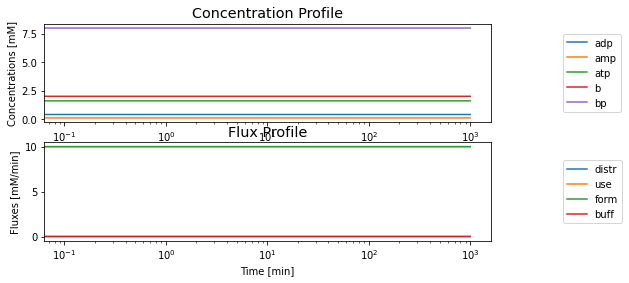

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 4),
                         )
(ax1, ax2) = axes.flatten()

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside", 
    plot_function="semilogx", 
    xlabel="Time [min]", ylabel="Concentrations [mM]", 
    title=("Concentration Profile", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, legend="right outside",
    plot_function="semilogx", 
    xlabel="Time [min]", ylabel="Fluxes [mM/min]", 
    title=("Flux Profile", XL_FONT));

We can compare the flux dynamics of the buffered vs. unbuffered system.  The buffered system has a much longer response time.  Once again, we consider a simulation where we increase the ATP use rate by a 'multiplier' in this figure:

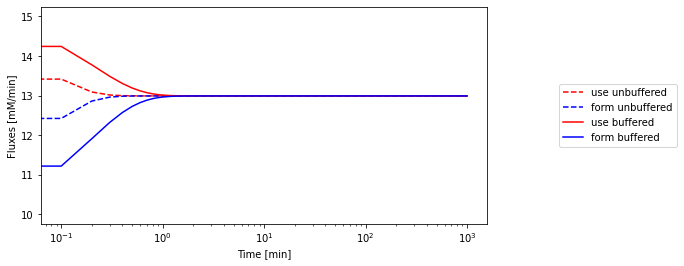

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4),
                       )

buff_strs = ["unbuffered", "buffered"]
linestyles = ["--", "-"]

t0, tf = (0, 1e3)
# Simulate both models with the disturbance
for i, model in enumerate([phos_traffic, phos_buffered]):
    sim = Simulation(model)
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf, tf*10 + 1),
        perturbations={"kf_use": "kf_use * 1.5"})

    plot_time_profile(
        flux_sol, observable=["use", "form"], ax=ax, 
        legend=(["use " + buff_strs[i], "form " + buff_strs[i]],
                "right outside"),
        plot_function="semilogx",
        xlabel="Time [min]", ylabel="Fluxes [mM/min]", 
        color=["red", "blue"], linestyle=linestyles[i])

**Figure 8.12:** The fluxes of ATP use and formation respond more slowly when the ATP buffer is present.

The response of the adenosine phosphate system can be simulated in the presence of a buffer. We choose the parameters as $\text{B}_{\mathrm{tot}}=10\ mM$, $K_{\mathrm{buff}}=1$, and $k_{\mathrm{buff}}=1000/min$ and all other conditions as in Figure 8.8. The results of the simulation are shown in Figure 8.13. The time response of the energy charge is shown, along with the buffer charge $\text{BP}/\text{B}_{\mathrm{tot}}$. We see that the fast response in the energy charge is now slower as the initial reaction is buffered by release of the high energy bonds that are bound to the buffer. The overall change in the energy charge is the same: it goes from 0.86 to 0.78. The charge of the buffer drops from 0.80 to 0.73 at the same time. 

![Figure-8-13](../images/Ch8/Figure-8-13.png)

**Figure 8.13:** Pictorial representation of the phosphate exchange among the adenosine phosphates and a buffering molecule. (a) The reaction schema. (b) A pictorial representation of the molecules, their charged states, and the definition of pooled variables*

#### Pooling and interpretation: E.C. buffering

A pictorial representation of the phosphate buffering is given in Figure 8.13. Here, a generalized definition of the overall phosphate charge is: 

$$\begin{equation} \text{overall charge} =  \frac{\text{overall occupancy}}{\text{overall capacity}} = \frac{2\ \text{ATP}+\text{ADP}+\text{BP}}{2\ (\text{ATP}+\text{ADP}+\text{AMP})+\text{BP} + \text{B}} \tag{8.15} \end{equation}$$

This combined charge system can be represented similarly to the representation in Figure 8.10.  Figure 8.14 shows a stacking of the buffer and adenosine phosphate capacity versus their charge. The total capacity to carry high-energy bonds is now 14.2 mM. The overall charge is 0.82 (or 11.64 mM concentration of high-energy bonds) in the system before the perturbation. The increased load brings the overall charge down to 0.74. 

![Figure-8-14](../images/Ch8/Figure-8-14.png)

**Figure 8.14:**  The representation of the energy and buffer charge versus the capacity (in mM on y-axis). The lumping of the two quantities into ‘overall’ quantities is illustrated. The case considered corresponds to the simulation in Figure 8.15.

To understand this effect, we first define more pools:

In [30]:
pools.update({
    "BC": "bp / (bp + b)",
    "Overall_Charge": "(2*atp + adp + bp) / (2*(atp + adp + amp) + bp + b)"})

and then plot the dynamic responses of the pools:

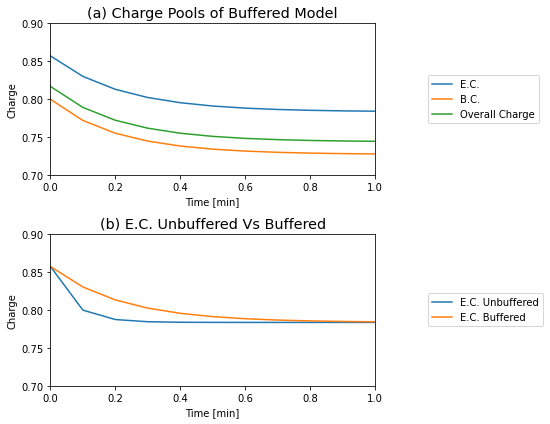

In [31]:
fig_8_15, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6),)
(ax1, ax2) = axes.flatten()
legend_labels = ["E.C. Unbuffered", "E.C. Buffered"]
for i, model in enumerate([phos_traffic, phos_buffered]):
    sim = Simulation(model)
    conc_sol, flux_sol = sim.simulate(
        model, time=(t0, tf, tf*10 + 1),
        perturbations={"kf_use": "kf_use * 1.5"})

    # Determine pools
    for pool_id, equation_str in pools.items():
        # Skip buffered charge for model with no buffer
        if i == 0 and pool_id in ["BC", "Overall_Charge"]:
            continue
        conc_sol.make_aggregate_solution(
            pool_id, equation=equation_str, update=True)

    if i == 1:
        # Plot the charge pools for the buffered solution
        plot_time_profile(
            conc_sol, observable=["EC", "BC", "Overall_Charge"], ax=ax1,
            legend=(["E.C.", "B.C.", "Overall Charge"], "right outside"),
            xlabel="Time [min]", ylabel="Charge", 
            xlim=(t0, 1), ylim=(.7, .9),
            title=("(a) Charge Pools of Buffered Model", XL_FONT));

    # Compare the buffered and unbuffered solutions
    plot_time_profile(
        conc_sol, observable=["EC"], ax=ax2,
        legend=(legend_labels[i], "right outside"),
        xlabel="Time [min]", ylabel="Charge", 
        xlim=(t0, 1), ylim=(.7, .9),
        title=("(b) E.C. Unbuffered Vs Buffered", XL_FONT));
fig_8_15.tight_layout()

**Figure 8.15:** Dynamic responses for Eqs.(8.4 - 8.8) with the buffering effect (Eq. (8.10)). (a) The Atkinson's energy charge (Eq. (8.9)) the buffer charge (Eq. (8.14)), and the overall charge (Eq. (8.15) are shown as a function of time. (b) Comparison of the buffered and unbuffered energy charge. $B_{\mathrm{tot}}=10 mM$, $K_{\mathrm{buff}}=1$ and $k_{\mathrm{buff}}=1000$. All other conditions are as in Figure 8.8; i.e., we simulate the response to a 'multiplier' increase in $k_{\mathrm{use}}$. Note the slower response of the E.C. in panel (b) when the system is buffered.

### Open system: long term adjustment of the capacity  
#### Inputs and outputs:  
Although the rates of formation and degradation of AMP are low, their effects can be significant. These fluxes will determine the total amount of the adenosine phosphates and thus their capacity to carry high energy bonds. The additional elementary rate laws needed to account for the rate of AMP formation and drain are: 

$$\begin{equation} v_{\mathrm{form,\ AMP}} = b_{1}, \ v_{\mathrm{drain}} = k_{\mathrm{drain}} * \text{AMP} \tag{8.16} \end{equation}$$

where $b_1$ is the net synthesis rate of AMP. The numerical values used are $b_{1}=0.03\ mM/min$ and $k_{\mathrm{drain}} = (0.03\ mM/min)/(0.1\ mM) = 0.3\ mM/min$. 

#### Updating the model for long term capacity adjustment
Define the AMP exchange reaction:

![Figure-8-16](../images/Ch8/Figure-8-16.png)

**Figure 8.16:** The trafficking of high-energy phosphate bonds with the buffer molecule and AMP exchange reactions.

In [32]:
# Copy the model to create a new, yet identical model instance 
phos_open = phos_buffered.copy()
phos_open.id += "_Open"

# Get MassMetabolite amp assoicated with the new copied model
amp = phos_open.metabolites.amp

# Define AMP formation
b1 = MassReaction("b1", reversible=False)
b1.add_metabolites({amp:1})
b1.kf = 0.03

# Define AMP drain
drain = MassReaction("drain", reversible=False)
drain.add_metabolites({amp:-1})
drain.kf = 0.3
# Add reactions to the model
phos_open.add_reactions([b1, drain])
# Set custom rate for formation of AMP
phos_open.add_custom_rate(b1, custom_rate=b1.kf_str)

# Display the net rate for AMP synthesis and draining
rate = strip_time(phos_open.rates[b1] - phos_open.rates[drain])
print(rate)
# Substitute values to check if steady state
print(rate.subs({
    sym.Symbol('amp'): amp.ic, # AMP concentration at steady state
    sym.Symbol('kf_drain'): drain.kf, # forward rate constant for drain reaction
    sym.Symbol('kf_b1'): b1.kf})) # Synthesis rate

-amp*kf_drain + kf_b1
0


With the specified parameters and initial conditions, the system is in a steady state, i.e. no net exchange of AMP.

#### Null spaces:  long term capacity adjustment
With the addition of the AMP exchanges, stoichiometric matrix six columns. 

In [33]:
phos_open.S

,distr,use,form,buff,b1,drain
adp,-2,1,-1,1,0,0
amp,1,0,0,0,1,-1
atp,1,-1,1,-1,0,0
b,0,0,0,-1,0,0
bp,0,0,0,1,0,0


It has still has a two-dimensional null space, that 1) represents and internal loop as the use and formation reactions are the exact opposites of each other, as before, and 2) an exchange pathways of AMP coming into the system and leaving the system. 

In [34]:
# Obtain nullspace
ns = nullspace(phos_open.S, rtol=1e-1)
# Transpose and iterate through nullspace, 
# dividing by the smallest value in each row.
ns = ns.T
for i, row in enumerate(ns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the nullspace is composed of only integers
    ns[i] = np.array([round(value) for value in new_row])

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(ns):
    ns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Revert transpose
ns = ns.T
# Create a pandas.DataFrame to represent the nullspace
pd.DataFrame(ns, index=[r.id for r in phos_open.reactions],
             columns=["Path 1", "Path 2"], dtype=np.int64)

,Path 1,Path 2
distr,0,0
use,1,0
form,1,0
buff,0,0
b1,0,1
drain,0,1


The left null space becomes one-dimensional.  The total amount of A is no longer conserved as AMP can now enter or leave the system, i.e. pathway 2) can have a net flux.  The buffer molecule, B, on the other hand is always contained within the system

In [35]:
# Obtain left nullspace
lns = left_nullspace(phos_open.S, rtol=1e-1)
# Iterate through left nullspace, 
# dividing by the smallest value in each row. 
for i, row in enumerate(lns):
    minval = np.min(abs(row[np.nonzero(row)]))
    new_row = np.array(row/minval)
    # Round to ensure the left nullspace is composed of only integers
    lns[i] = np.array([round(value) for value in new_row])

# Ensure positive stoichiometric coefficients if all are negative
for i, space in enumerate(lns):
    lns[i] = np.negative(space) if all([num <= 0 for num in space]) else space

# Create a pandas.DataFrame to represent the left nullspace
pd.DataFrame(lns, index=["Total B"], 
             columns=phos_open.metabolites, dtype=np.int64)

,adp,amp,atp,b,bp
Total B,0,0,0,1,1


#### Dynamic simulations: long term capacity adjustment
Initially, the open system is in a steady-state. Once again, we consider a simulation where we increase the ATP use rate by a 'multiplier'. This system has a bi-phasic response for the values of the kinetic constants. We can start the system in a steady state at $t=0^-$ and simulate the response for increasing the ATP load by shifting the value of $k_{\mathrm{use}}^\rightarrow$ by a 'multiplier' at $t=0$, as before. The initial rapid response is similar to what is shown in Figure 8.8a, where the concentration of ATP drops in response to the load and the concentrations of ADP and AMP rise. This initial response is followed by a much slower response where all three concentrations drop. 

In [36]:
t0, tf = (0, 1e3)
sim = Simulation(phos_open, verbose=True)
sim.find_steady_state(models=phos_open, strategy="simulate")
conc_sol, flux_sol = sim.simulate(
    phos_open, time=(t0, tf, tf*10 + 1), 
    perturbations={"kf_use": "kf_use * 1.5"})
pools.update({"Capacity": "2*(atp + adp + amp)"})
# Determine pools
for pool_id, equation_str in pools.items():
    # Skip buffered charge for model with no buffer
    conc_sol.make_aggregate_solution(
        pool_id, equation=equation_str, update=True)

Successfully loaded MassModel 'Phosphate_Trafficking_Buffered_Open' into RoadRunner.


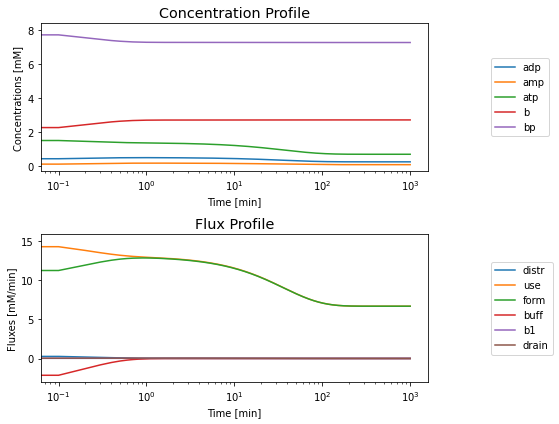

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6),
                         )
(ax1, ax2) = axes.flatten()
plot_time_profile(
    conc_sol, ax=ax1, observable=phos_open.metabolites,
    legend="right outside",
    plot_function="semilogx", 
    xlabel="Time [min]", ylabel="Concentrations [mM]", 
    title=("Concentration Profile", XL_FONT));

plot_time_profile(
    flux_sol, ax=ax2, observable=phos_open.reactions,
    legend="right outside",
    plot_function="semilogx", 
    xlabel="Time [min]", ylabel="Fluxes [mM/min]", 
    title=("Flux Profile", XL_FONT));
fig.tight_layout()

#### Interpretation of the bi-phasic response

This bi-phasic response can be examined further by looking at dynamic phase portraits of key fluxes (Figure 8.17) and key pools (Figure 8.18). 

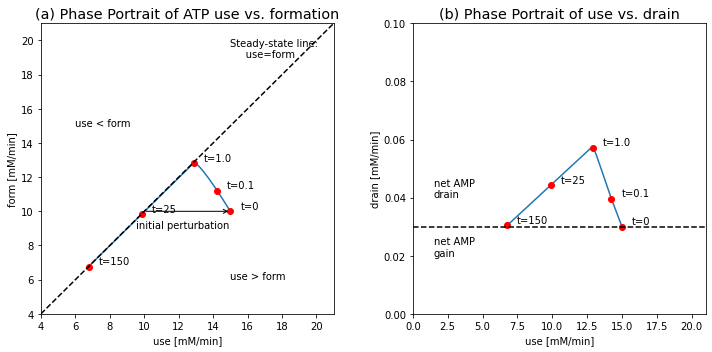

In [38]:
fig_8_17, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
(ax1, ax2) = axes.flatten()

label = "{0} [mM/min]"
plot_phase_portrait(
    flux_sol, x="use", y="form", ax=ax1,
    xlim=(4, 21), ylim=(4, 21), 
    xlabel=label.format("use"), ylabel=label.format("form"), 
    title=("(a) Phase Portrait of ATP use vs. formation", XL_FONT),
    annotate_time_points=[0, 1e-1, 1e0, 25, 150],
    annotate_time_points_color=["red"],
    annotate_time_points_labels=True);

# Annotate plot
line_data = [i for i in range(0, 22)]
ax1.plot(line_data, line_data, ls="--", color="black");
ax1.annotate("use < form", xy=(6, 15));
ax1.annotate("use > form", xy=(15, 6));
ax1.annotate("Steady-state line:\n     use=form", xy=(15, 19));
ax1.annotate("initial perturbation", xy=(9.5, 9), xycoords="data");
ax1.annotate("", xy=(flux_sol["use"][0], flux_sol["form"][0]),
             xytext=(10, 10), textcoords="data",
             arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));

plot_phase_portrait(
    flux_sol, x="use", y="drain", ax=ax2,
    xlim=(0, 21), ylim=(0, 0.1), 
    xlabel=label.format("use"), ylabel=label.format("drain"),
    title=("(b) Phase Portrait of use vs. drain", XL_FONT),
    annotate_time_points=[0, 1e-1, 1e0, 25, 150],
    annotate_time_points_color=["red"],
    annotate_time_points_labels=True);

# Annotate plot
ax2.plot(line_data, [0.03]*22, ls="--", color="black");
ax2.annotate("net AMP\ngain", xy=(1.5, 0.02));
ax2.annotate("net AMP\ndrain", xy=(1.5, 0.04));
fig_8_17.tight_layout()

**Figure 8.17:** Dynamic phase portraits of fluxes for the simulation of the adenosine phosphate system with formation and drain of AMP (Eq. (8.16)). (a) the ATP use $(v_{\mathrm{use}})$ versus the ATP formation rate $(v_{\mathrm{form}})$. (b) the ATP use $(v_{\mathrm{use}})$ versus the AMP drain $(v_{\mathrm{drain}})$.

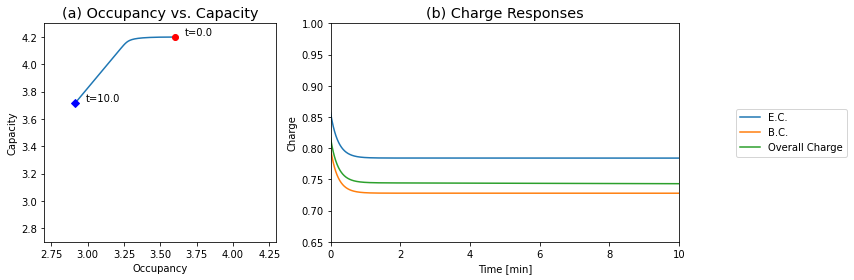

In [39]:
fig_8_18 = plt.figure(figsize=(12, 4))
gs = fig_8_18.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 1.5])

ax1 = fig_8_18.add_subplot(gs[0, 0])
ax2 = fig_8_18.add_subplot(gs[0, 1])

plot_phase_portrait(
    conc_sol, x="Occupancy", y="Capacity", ax=ax1,
    time_vector=np.linspace(t0, 10, int(1e6)),
    xlim=(2.7, 4.3), ylim=(2.7, 4.3),
    xlabel="Occupancy", ylabel="Capacity",
    title=("(a) Occupancy vs. Capacity", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_labels=True);

plot_time_profile(
    conc_sol, observable=["EC", "BC", "Overall_Charge"], ax=ax2,
    legend=(["E.C.", "B.C.", "Overall Charge"], "right outside"),
    time_vector=np.linspace(t0, 10, int(1e6)),
    xlabel="Time [min]", ylabel="Charge",
    xlim=(t0, 10), ylim=(0.65, 1),
    title=("(b) Charge Responses", XL_FONT));
fig_8_18.tight_layout()

**Figure 8.18:** The Energy Charge response. (a) Dynamic phase portrait of 2ATP+ADP versus 2(ATP+ADP+AMP). (b) The response of E.C., B.C., and overall charge.

* First, we examine how the system balances the use of ATP $(v_{\mathrm{use}})$ with its rate of formation $(v_{\mathrm{form}})$, see Figure 8.17. At $t=0$ the system is at rest at $v_{\mathrm{use}}=v_{\mathrm{form}}=10.0\ mM/min$. Then the system is perturbed by moving the ATP drain, $v_{\mathrm{use}}$, to 15.0 mM/min, as before. The initial response is to increase the formation rate of ATP to about 13 mM/min with the simultaneous drop in the use rate to about the same number, due to a net drop in the concentration of ATP during this period. The rate of ATP use and formation is approximately the same at this point in time. Then, during the slower response time, the use and formation rates of ATP are similar and the system moves along the 45 degree line to a new steady state point at 6.67 mM/min. 


* The slow dynamics are associated with the inventory of the adenosine phosphates (ATP + ADP + AMP). The AMP drain can be graphed versus the ATP use, see Figure 8.17b. Initially, the AMP drain increases rapidly as the increased ATP use leads to ADP buildup that gets converted into AMP by adenylate kinase $(v_{\mathrm{distr}})$. The AMP drain then drops and sets at the same rate to balance the formation rate, set at 0.03 mM/min. 


* We can graph the occupancy against the capacity (Figure 8.18a). During the initial response, the occupancy moves while the capacity is a constant. Then, during the slower phase, the two move at a constant ratio. This gives a bi-phasic response of the energy charge (Figure 8.18b). In about a minute, the energy charge changes from 0.86 to about 0.77 and then stays a constant. The energy charge is roughly a constant even though all the other concentrations are changing. 


This feature of keeping the energy charge a constant while the capacity is changing has a role in a variety of physiological responses, from blood storage to the ischemic response in the heart. Note that this property is a stoichiometric one; no regulation is required to produce this effect. 

## Charging Substrates and Recovery of High-Energy Bonds
### Reaction mechanism: 
As discussed in Section 8.2, most catabolic pathways generate energy (and other metabolic resources) in the form of activated (or charged) carrier molecules. Before energy can be extracted from a compound, it is typically activated by the use of metabolic resources (a biological equivalent of "it takes money to make money"). This basic structure shown in Figure 2.5 is redrawn in Figure 8.19a where one ATP molecule is used to 'charge' a substrate $(x_1)$ with one high-energy bond to form an intermediate $(x_2)$. This intermediate is then degraded through a process wherein two ATP molecules are synthesized and an inorganic phosphate is incorporated. The net gain of ATP is 1 for every $(x_2)$ metabolized, and this ATP molecule can then be used to drive a process $v_{\mathrm{load}}$ that uses an ATP molecule. The trafficking of high-energy phosphate bonds is shown pictorially in Figure 8.19b. 

![Figure-8-19](../images/Ch8/Figure-8-19.png)

**Figure 8.19:** Coupling of the adenosine phosphates with a skeleton metabolic pathway. (a) The reaction map. (b) A pictorial view of the molecules emphasizing the exchange of the high-energy phosphate group (solid circle). The blue square is AMP. The rate laws used are: $b_1 = 0.03\ mM/min.$; $b_2 = 5\ mM/min.$; $k_{\mathrm{drain}}=b_1/0.1$; $k_{\mathrm{load}}=5/1.6$; $k_1=5/0.4$. The flux of $b_2$ was set to 5 mM/min, as the ATP production rate is double that number, thus the steady state value for ATP production is 10 mM/min, to match what is discussed in section 8.3.

In [40]:
# Create model
phos_recovery = MassModel("Phosphate_Recovery", array_type="dense",
                          dtype=np.int64)
# Define metabolites
atp = MassMetabolite("atp")
adp = MassMetabolite("adp")
amp = MassMetabolite("amp")
pi = MassMetabolite("pi")
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")
x3 = MassMetabolite("x3")
# Define reactions
b1 = MassReaction("b1", reversible=False)
b1.add_metabolites({amp:1})

distr = MassReaction("distr")
distr.add_metabolites({adp: -2, amp: 1, atp:1})

load = MassReaction("load", reversible=False)
load.add_metabolites({atp: -1, adp: 1, pi: 1})

drain = MassReaction("drain", reversible=False)
drain.add_metabolites({amp:-1})

b2 = MassReaction("b2", reversible=False)
b2.add_metabolites({x1: 1})

v1 = MassReaction("v1", reversible=False)
v1.add_metabolites({atp: -1, x1: -1, adp: 1, x2: 1})

v2 = MassReaction("v2", reversible=False)
v2.add_metabolites({adp: -2, pi: -1, x2: -1, atp: 2, x3: 1})

DM_x3 = MassReaction("DM_x3", reversible=False)
DM_x3.add_metabolites({x3: -1})

# Add reactions to model
phos_recovery.add_reactions([b1, distr, load, drain, b2, v1, v2, DM_x3])

# Define initial conditions and parameters
atp.ic = 1.6
adp.ic = 0.4
amp.ic = 0.1
pi.ic = 2.5
x1.ic = 1
x2.ic = 1
x3.ic = 1

b1.kf = 0.03
distr.kf = 1000
distr.Keq = 1
load.kf = 5/1.6
drain.kf = 0.3
b2.kf = 5
v1.kf = 5/1.6
v2.kf = 5/0.4
DM_x3.kf = 5

# Set custom rate for source reactions 
phos_recovery.add_custom_rate(b1, custom_rate=b1.kf_str)
phos_recovery.add_custom_rate(b2, custom_rate=b2.kf_str)

#### The dynamic mass balances:  
The dynamic mass balance equations that describe this process are: 

$$\begin{align} \frac{dx_1}{dt} &= b_2 - v_1 &\tag{8.17a} \\ \frac{dx_2}{dt} &= v_1 - v_2 &\tag{8.17b} \\ \frac{d\text{ATP}}{dt} &= -(v_1 + v_{\mathrm{load}}) + 2v_2 + v_{\mathrm{distr}} &\tag{8.17c} \\ \frac{d\text{ADP}}{dt} &= (v_1 + v_{\mathrm{load}}) - 2v_2 - 2v_{\mathrm{distr}} &\tag{8.17d} \\ \frac{d\text{AMP}}{dt} &= b_1 - v_{\mathrm{drain}} + v_{\mathrm{distr}} &\tag{8.17e} \\ \end{align}$$

To integrate the reaction schema in Figure 8.13a with this skeleton pathway, we have replaced the use rate of ATP $(v_{\mathrm{use}})$ with $v_1 + v_{\mathrm{load}}$ and the formation rate of ATP $(v_{\mathrm{form}})$ with $2v_2$. 

#### Dynamic simulation:  
The flow of substrate into the cell, given by $b_2$, will be set to 5 mM/min in the simulation to follow to set the gross ATP production at 10 mM/min. The response of this system can be simulated to a change in the ATP load parameter, as in previous examples. The difference from the previous examples here is that the net ATP production rate is 5 mM/min. 

The time response of the concentrations and fluxes are shown in Figure 8.20, the flux phase portraits in Figure 8.21, and the pools and ratios in Figure 8.22.

In [41]:
t0, tf = (0, 100)
sim = Simulation(phos_recovery, verbose=True)
sim.find_steady_state(models=phos_recovery, strategy="simulate",
                      update_values=True)
conc_sol, flux_sol = sim.simulate(
    phos_recovery, time=(t0, tf, tf*10 + 1), 
    perturbations={"kf_load": "kf_load * 1.5"},
    interpolate=True)

pools = {"Occupancy": "adp + 2*atp", 
         "Capacity": "2*(atp + adp + amp)",
         "EC": "(2*atp + adp) / (2*(atp + adp + amp))"}

for pool_id, equation_str in pools.items():
    conc_sol.make_aggregate_solution(
        pool_id, equation=equation_str, update=True)

netfluxes = {
    "load_total": "v1 + load", 
    "generation": "2*v2", 
    "drain_total": "drain"}
for flux_id, equation_str in netfluxes.items():
    # Skip buffered charge for model with no buffer
    flux_sol.make_aggregate_solution(
        flux_id, equation=equation_str, update=True)

Successfully loaded MassModel 'Phosphate_Recovery' into RoadRunner.


ERROR: Something unexpected occurred and the model could not be loaded into the current RoadRunner instance. Therefore initializing a new RoadRunner instance for the Simulation.


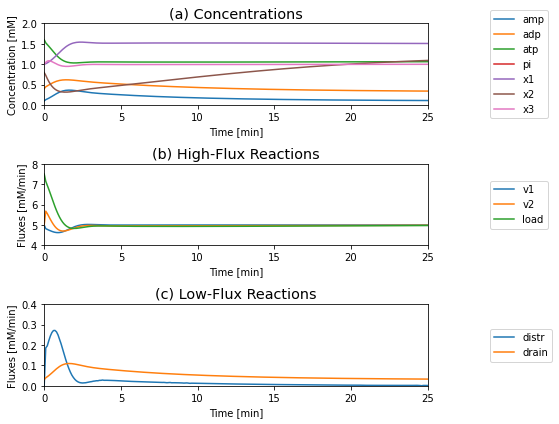

In [42]:
fig_8_20, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6))
(ax1, ax2, ax3) = axes.flatten()

plot_time_profile(
    conc_sol, observable=phos_recovery.metabolites,
    ax=ax1, legend="right outside", 
    xlim=(t0, 25), ylim=(0, 2.0),
    xlabel="Time [min]", ylabel="Concentration [mM]",
    title=("(a) Concentrations", XL_FONT));

plot_time_profile(
    flux_sol, observable=["v1", "v2", "load"], 
    ax=ax2, legend="right outside", 
    xlim=(t0, 25), ylim=(4, 8),
    xlabel="Time [min]", ylabel="Fluxes [mM/min]",
    title=("(b) High-Flux Reactions", XL_FONT));

plot_time_profile(
    flux_sol, observable=["distr", "drain"], 
    ax=ax3, legend="right outside", 
    xlim=(t0, 25), ylim=(0, .4),
    xlabel="Time [min]", ylabel="Fluxes [mM/min]",
    title=("(c) Low-Flux Reactions", XL_FONT));
fig_8_20.tight_layout()

**Figure 8.20:** The response of the systems shown in Figure 8.19 to a 50% increase in the ATP load rate constant. (a) Dynamic response of the concentrations on a fast and slow time scale. (b) Dynamic response of the main fluxes on a fast and slow time scale. (c) Dynamic response of the AMP determining fluxes on a fast and slow time scale. Parameter values are the same as in Figure 8.19.

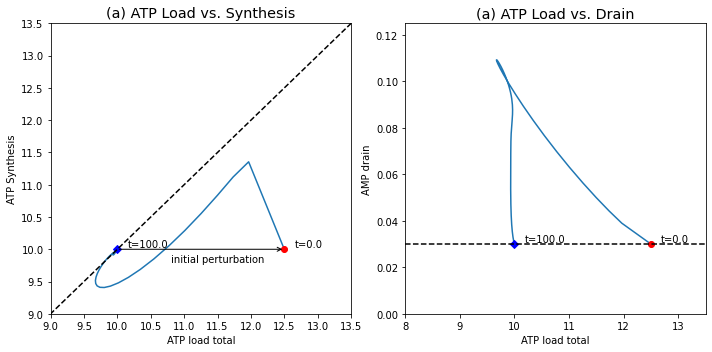

In [43]:
fig_8_21, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
(ax1, ax2) = axes.flatten()

plot_phase_portrait(
    flux_sol, x="load_total", y="generation", ax=ax1, 
    xlabel="ATP load total", ylabel="ATP Synthesis", 
    xlim=(9, 13.5), ylim=(9, 13.5), 
    title=("(a) ATP Load vs. Synthesis", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_labels=True);

# Annotate plot
line_data = [i for i in range(8, 15)]
ax1.plot(line_data, line_data, ls="--", color="black");
ax1.annotate(
    "", xy=(flux_sol["load_total"](0), flux_sol["generation"](0)),
    xytext=(10, 10), textcoords="data",
    arrowprops=dict(arrowstyle="->",connectionstyle="arc3"));
ax1.annotate("initial perturbation", xy=(
    flux_sol["load_total"](0) - 1.7, 
    flux_sol["generation"](0) - 0.2));

plot_phase_portrait(
    flux_sol, x="load_total", y="drain_total", ax=ax2, 
    xlabel="ATP load total", ylabel="AMP drain", 
    xlim=(8, 13.5), ylim=(0, 0.125),
    title=("(a) ATP Load vs. Drain", XL_FONT),
    annotate_time_points="endpoints",
    annotate_time_points_labels=True);

ax2.plot(line_data, [0.03] * 7, ls="--", color="black");
fig_8_21.tight_layout()

**Figure 8.21:** The response of the system shown in Figure 8.19 to a change in the ATP load rate constant. (a) ATP load versus ATP synthesis rate. (b) ATP load versus AMP drainage rate. You can compare this response to Figure 8.17.

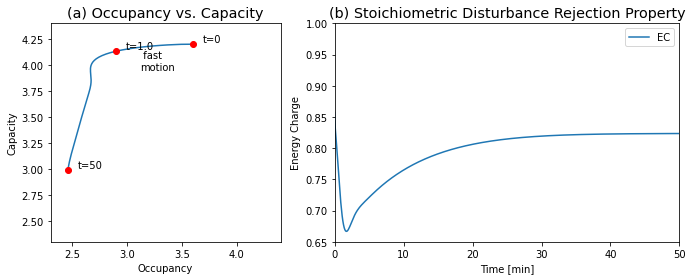

In [44]:
fig_8_22 = plt.figure(figsize=(10, 4))
gs = fig_8_22.add_gridspec(nrows=1, ncols=2, width_ratios=[1, 1.5])

ax1 = fig_8_22.add_subplot(gs[0, 0])
ax2 = fig_8_22.add_subplot(gs[0, 1])

plot_phase_portrait(
    conc_sol, x="Occupancy", y="Capacity", ax=ax1,
    xlim=(2.3, 4.4), ylim=(2.3, 4.4),
    xlabel="Occupancy", ylabel="Capacity",
    title=("(a) Occupancy vs. Capacity", XL_FONT),
    annotate_time_points=[t0, 1e0, 50],
    annotate_time_points_color=["red"],
    annotate_time_points_labels=True);
# Annotate plot
ax1.annotate(" fast\nmotion\n", xy=(conc_sol["Occupancy"](0.3) - .25, 
                                   conc_sol["Capacity"](0.3) - .35))

plot_time_profile(
    conc_sol, observable=["EC"], ax=ax2, legend="best",
    xlim=(t0, 50), ylim=(0.65, 1),
    xlabel="Time [min]", ylabel="Energy Charge",
    title=("(b) Stoichiometric Disturbance Rejection Property", XL_FONT));
fig_8_22.tight_layout()

**Figure 8.22:** The response of the system shown in Figure 8.19 to a change in the ATP load rate constant. (a) Dynamic phase portrait of the pools 2ATP+ADP versus 2(ATP+ADP+AMP).  (b) Energy charge ratio as a function of time. You can compare this response to Figure 8.18.

### Interpretation:  
We can make the following observations from this dynamic response: 

* The concentrations move on two principal time scales (Figure 8.20): a fast time scale that is about three to five minutes, and a slower time scale that is about 50 min. ATP and $x_1$ move primarily on the fast time scale, whereas ADP, AMP, and $x_2$ move on the slower time scale. You can see this clearly by changing time in Figure 8.20.

* Initially $v_{\mathrm{load}}$ increases sharply, and $v_2$ increases and $v_1$ decreases to meet the increased load. The three high flux reactions $v_1$, $v_2$, and $v_{\mathrm{load}}$ restabilize at about 5 mM/min after about a three to five minute time frame, after which they are closely, but not fully, balanced (Figure 8.20). 

* The dynamic phase portrait, Figure 8.21a, shows that the overall ATP use $(v_1 + v_{\mathrm{load}})$ quickly moves to about 12.5 mM/min while the production rate $(2v_2)$ is about 10 mM/min. Following this initial response, the ATP use drops and the ATP synthesis rate increases to move towards the 45 degree line. The 45 degree line is not reached. After 0.1 min, $v_2$ starts to drop and the system moves somewhat parallel to the 45 degree line until 1.5 min have passed. At this time the ATP concentration has dropped to about 1.06 mM, which makes the ATP use and production rate approximately balanced. Following this point, both the use and production rate increase slowly and return the system back to the initial point where both have a value of 10 mM/min. Since the input rate of $x_1$ is a constant, the system has to return to the initial state. 

* AMP initially increases leading to a net drain of AMP from the system. This drain unfolds on a long time scale leading to a net flux through the adenylate kinase that decays on the slower time scale. The effects of AMP drainage can be seen in the flux phase portrait in Figure 8.21b. Initially the AMP drain increases as the ATP usage drops close to its eventual steady state. Then the vertical motion in the phase portrait shows that there is a slower motion in which the ATP usage does not change much but the AMP drainage rate drops to match its input rate at 0.03 mM/hr. 

* The dynamic response of the energy charge (Figure 8.22b) shows that it drops on the faster time scale from an initial value of 0.86 to reach a minimum of about 0.67 at about 1.5 min. This initial response results from the increase in the ATP load parameter of 50%. After this initial response, the energy charge increases on the slower time scale to an eventual value of about 0.82. 

* Notice that this secondary response is not a result of a regulatory mechanism, but is a property that is built into the stoichiometric structure and the values of the rate constants that lead to the time scale separation. 

## Summary   

* Most biochemical reactions are bilinear. Six of the seven categories of enzymes catalyze bilinear reactions. 

* The bilinear properties of biochemical reactions lead to complex patterns of exchange of key chemical moieties and properties. Many such simultaneous exchange processes lead to a 'tangle of cycles' in biochemical reaction networks. 

* Skeleton (or scaffold) dynamic models of biochemical processes can be carried out using dynamic mass balances based on elementary reaction representations and mass action kinetics. 

* Complex kinetic models are built in a bottom-up fashion, adding more details in a step-wise fashion, making sure that every new feature is consistently integrated. This chapter demonstrated a four-step analysis of the ATP cofactor sub-network and then its integration to a skeleton ATP generating pathway. 

* Once dynamic network models are formulated, the perturbations to which we simulate their responses are in fluxes, typically the exchange and demand fluxes. 

* A recurring theme is the formation of pools and the state of those pools in terms of how their total concentration is distributed among its constituent members. 

* Some dynamic properties are a result of the stoichiometric structure and do not result from intricate regulatory mechanisms or complex kinetic expressions. 

$\tiny{\text{© B. Ø. Palsson 2011;}\ \text{This publication is in copyright.}\\ \text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}$